In [1]:
from imf import Salpeter,Kroupa,ChabrierLogNormal,ChabrierPowerLaw,KoenConvolvedPowerLaw
from imf import make_cluster
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
import matplotlib.pyplot as plt
from time import perf_counter

In [2]:
def normalization(max_star,massfunc):
    return 1/massfunc.integrate(max_star,massfunc.mmax)[0]

def hist_props(stars,massfunc):
    edges = [stars[0]*1.01]
    for i in range(1,np.floor_divide(len(stars),10)):
        try:
            edge = (stars[10*i-1]+stars[10*i])/2
            edges.append(edge)
        except(IndexError):
            continue
    edges.append(massfunc.mmin)
    edges = np.array(edges)[::-1]
    dm = edges[1:]-edges[:-1]

    weights = np.ones(len(stars))
    for i in range(len(dm)):
        weights[np.logical_and(stars > edges[i],stars < edges[i+1])] *= 1/dm[i]
        
    return edges,weights

To use optimal sampling, enter it as input to the "sampling' keyword in "make_cluster":

In [3]:
opt_cl = make_cluster(1e3,'kroupa',sampling='optimal')
rand_cl = make_cluster(1e3,'kroupa',stop_criterion='nearest')

Total cluster mass is 999.986 (limit was 1000)
Total cluster mass is 1016.52 (limit was 1000)


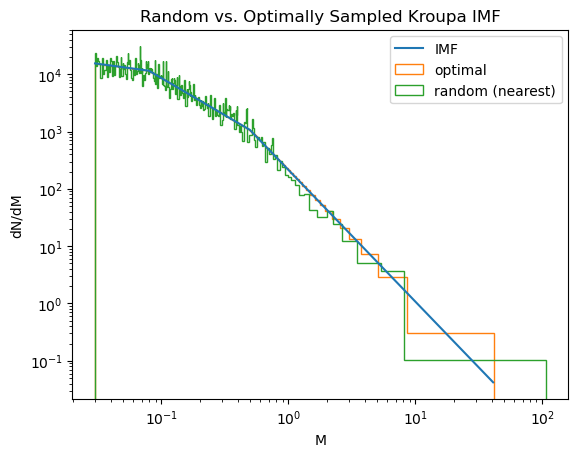

In [4]:
plt.figure()
massfunc = Kroupa()
k = normalization(opt_cl[0],massfunc)
plt.plot(opt_cl,k*massfunc(opt_cl),label='IMF')

edges,weights = hist_props(opt_cl,massfunc)
n,bins,patches = plt.hist(opt_cl,bins=edges,weights=weights,histtype='step',
                          label='optimal',zorder=-2)

rand_cl.sort()
rand_cl = rand_cl[::-1]
edges,weights = hist_props(rand_cl,massfunc)
n,bins,patches = plt.hist(rand_cl,bins=edges,weights=weights,histtype='step',
                          label='random (nearest)',zorder=-1)

plt.title('Random vs. Optimally Sampled Kroupa IMF')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('M'); plt.ylabel('dN/dM')
plt.legend()

It will work with any provided mass function, and you can use make_cluster the same way you would normally use it. However, there are a few considerations specific to optimal sampling that should be kept in mind.

-Optimal sampling assumes a relationship between the mass of a cluster, M_cl, and the largest possible mass of a constituent star, m_max. It also assumes that there is at most one star which can attain this mass. The masses of other stars are obtained by integrating the mass function (scaled to produce one star with mass m_max or greater) all the way down to the minimum.

-Optimal sampling is not random; the stars are determined based on the provided mass function and cluster mass. The "stop_criterion" keyword therefore has no significance to optimal sampling. 

-The stop criterion for optimal sampling is by default the minimum possible stellar mass (i.e. when the available mass is less than that needed to form a star, which is determined by the mmin of the provided mass function. If you instead want to cut off earlier, you can specify a tolerance larger than mmin, and optimal sampling will terminate when the available mass no longer exceeds that tolerance. (The larger of the two values will be used.)

-You can provide a mass function with an mmin of zero. However, you must then specify a mass tolerance with the "tolerance" keyword, or else optimal sampling will never terminate (there can't be any zero-mass stars, so the mass will asymptote to zero but will not reach it.) This will be prompted.

-Currently, the implementation of optimal sampling has difficulties with mass functions of the KoenConvolvedPowerLaw type. These result from the implementation of KoenConvolvedPowerLaw, which relies on numerical integration and interpolation due to not being feasible to implement analytically. (For more details, see the "koen" notebook.) The total mass of the returned cluster should be close to the provided mass reservoir, but the cluster may not reproduce the low-mass end of the distribution as accurately as for other mass functions.

TESTS

In [5]:
def make_hist(stars,massfunc):
    edges,weights = hist_props(stars,massfunc)
    plt.figure()
    k = normalization(stars[0],massfunc)
    plt.plot(stars,k*massfunc(stars),label='IMF')
    n,bins,patches = plt.hist(stars,bins=edges,weights=weights,histtype='step',label='sampled')
    #plt.title('Random vs. Optimally Sampled Kroupa IMF')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('M'); plt.ylabel('dN/dM')
    plt.legend()

In [6]:
M_res = 1000

Total cluster mass is 999.797 (limit was 1000)


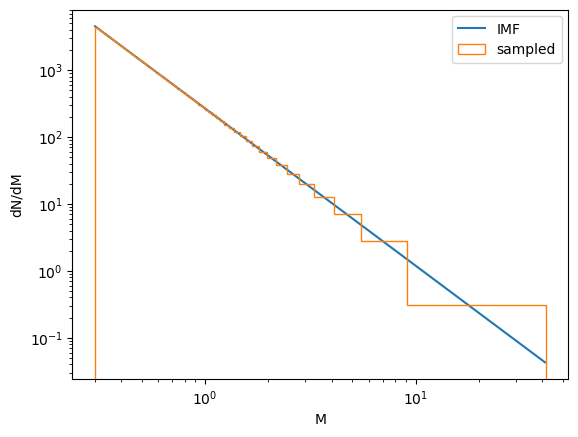

In [7]:
sp = Salpeter()
cl = make_cluster(M_res,massfunc=sp,sampling='optimal')
assert M_res-cl.sum() <= sp.mmin
make_hist(cl,sp)

Total cluster mass is 999.986 (limit was 1000)


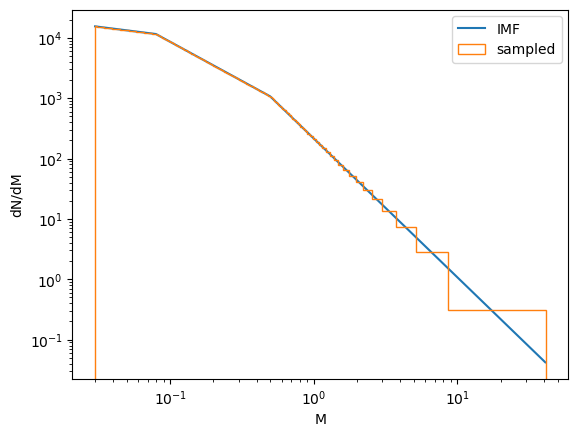

In [8]:
kr = Kroupa()
cl = make_cluster(M_res,massfunc=kr,sampling='optimal')
assert M_res-cl.sum() <= kr.mmin
make_hist(cl,kr)

Total cluster mass is 999.987 (limit was 1000)


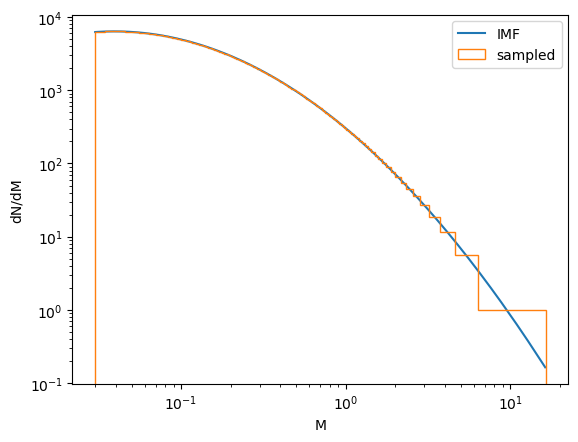

In [9]:
chl = ChabrierLogNormal(mmin=0.03)
cl = make_cluster(M_res,massfunc=chl,sampling='optimal')
assert M_res-cl.sum() <= chl.mmin
make_hist(cl,chl)

Total cluster mass is 1000.0 (limit was 1000)


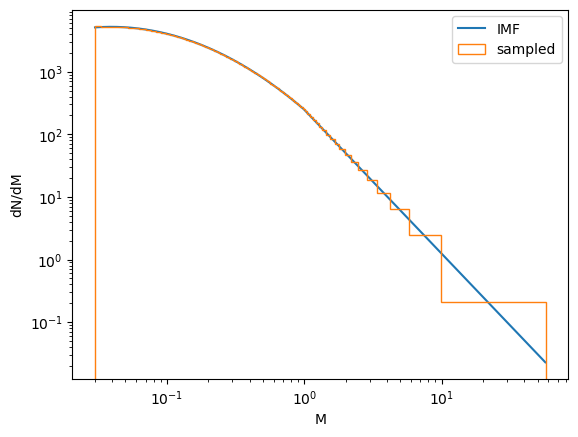

In [10]:
chp = ChabrierPowerLaw(mmin=0.03)
cl = make_cluster(M_res,massfunc=chp,sampling='optimal')
assert M_res-cl.sum() <= chp.mmin
make_hist(cl,chp)

As mentioned above, using optimal sampling for KoenConvolvedPowerLaws can yield slightly incorrect results due to the nature of their implementation. Optimal sampling will catch this when it occurs and will return the generated cluster; in most cases, the total mass should still be comparable to the expected mass, as the differences do not manifest until the low-mass end. If that presents a problem, accuracy may be improvable by increasing the number of subdivisions permitted to scipy.integrate.quad, which handles the underlying integration.

/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:1011: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  limit=self._limit, **kwargs)
/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:1022: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrato

Reached provided lower mass bound; stopping
Total cluster mass is 999.902 (limit was 1000)
Optimally sampled cluster mass too low. Increasing subdivisions...


/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:1011: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  limit=self._limit, **kwargs)
/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:1022: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  limit=self._limit, **kwargs)


Total cluster mass is 999.975 (limit was 1000)


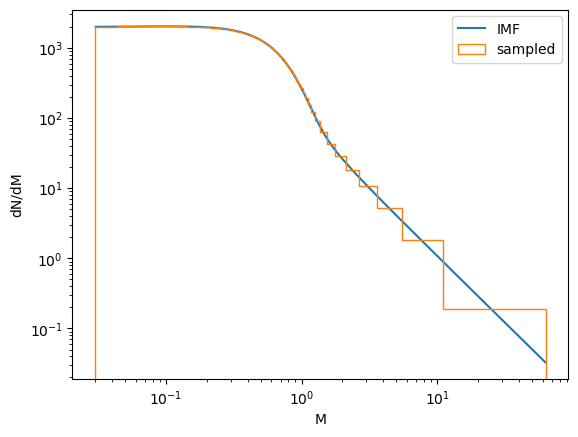

In [11]:
koc = KoenConvolvedPowerLaw(0.03,120,0.9,0.4,limit=50)
cl = make_cluster(M_res,massfunc=koc,sampling='optimal')
try:
    assert M_res-cl.sum() <= koc.mmin
except(AssertionError):
    print('Optimally sampled cluster mass too low. Increasing subdivisions...')
    koc.limit = 100
cl = make_cluster(M_res,massfunc=koc,sampling='optimal')
assert M_res-cl.sum() <= koc.mmin
make_hist(cl,koc)

Example of providing a mass function with mmin = 0 and tolerance = 0. Optimal sampling will throw a ValueError if a nonzero (or negative, or non-finite) lower limit is not provided.

/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:541: RuntimeWarning: divide by zero encountered in log
  if not np.isfinite(np.log(mmin)):
/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:542: RuntimeWarning: divide by zero encountered in log
  if not np.isfinite(np.log(tolerance)):


Caught exception due to zero mmin and tolerance.
Total cluster mass is 999.907 (limit was 1000)


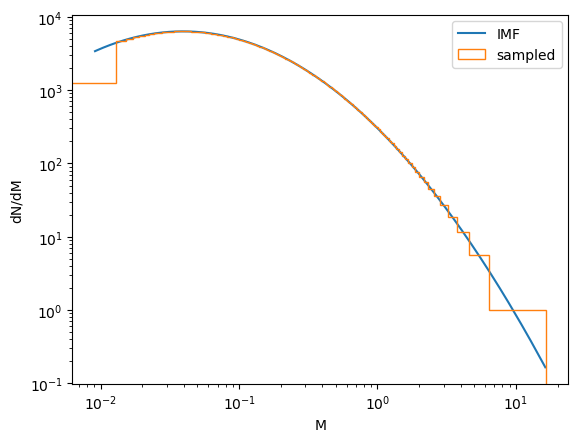

In [12]:
chl = ChabrierLogNormal()
try:
    cl = make_cluster(1e3,massfunc=chl,sampling='optimal')
except(ValueError):
    print('Caught exception due to zero mmin and tolerance.')
tolerance = 0.1
cl = make_cluster(1e3,massfunc=chl,sampling='optimal',tolerance=tolerance)
assert M_res-cl.sum() <= tolerance
make_hist(cl,chl)

Optimal sampling is a fundamentally iterative process, as the mass of each star is dependent on the previous star. As such, making a cluster requires integrating the mass function (properly normalized) from the most massive star down to the lower mass limit and adding each newly found star to the total mass. For massive clusters and standard stellar mass limits, this can take a very long time.

In [ ]:
chl = ChabrierLogNormal(mmin=0.03,mmax=150)
t0 = perf_counter()
cl = make_cluster(M_res*100,massfunc=chl,sampling='optimal')
tot_time = perf_counter() - t0
print(f'Total time to make this cluster was {np.round(tot_time)} seconds.')
assert M_res-cl.sum() <= chl.mmin
make_hist(cl,chl)

Total cluster mass is 99999.992 (limit was 100000)
Total time to make this cluster was 2362.0 seconds.
